In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances;
#using ForwardDiff
#using ProgressMeter
#using BenchmarkTools;

In [53]:
#Hyperparameters
n = 50
N = n*4
σₐ = 0.02
σᵧ = 1.0 #Likelihood variance
α = 0.9 #"Regularization" Term for NN Parameters
σₖ = sqrt(1/α) #Gaussian Variance for NN Parameters
k_range = 12
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

#Successful Hyperparameters - December 7th
n = 50
N = n*4
σₐ = 0.02
σᵧ = 1.0 #Likelihood variance
α = 0.9 #"Regularization" Term for NN Parameters
σₖ = sqrt(1/α) #Gaussian Variance for NN Parameters
k_range = 12
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

L_within=10
eps_within=uniform(0.1,0.15)
L_across=20
eps_across=uniform(0.01,0.15)
across_iters=10;

#Birth/Death: Standard Death, Birth --> insert node at random location
#To-do: Random neuron death!

In [7]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function trace_acc(trace)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    return acc
end

mₖ(k) = k*4 + 1;

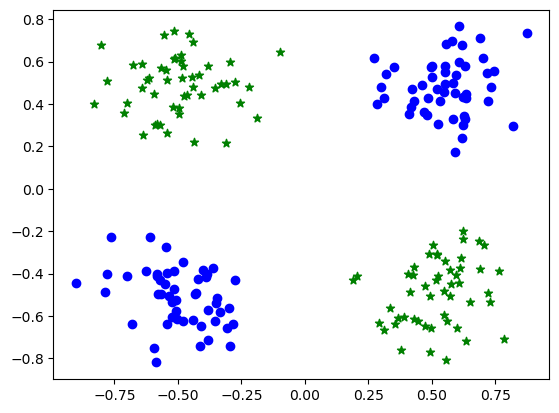

In [4]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [-0.5, -0.5]
    μ₂ = [-0.5, 0.5]
    μ₃ = [0.5, 0.5]
    μ₄ = [0.5, -0.5]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

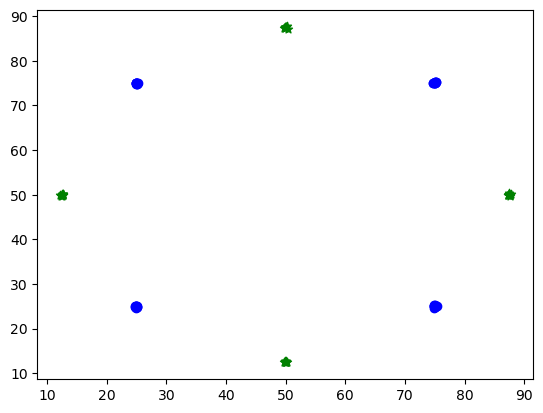

In [13]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    a = 100
    μ₁ = [0.25, 0.25].*a
    μ₂ = [0.5, 0.125].*a
    μ₃ = [0.25, 0.75].*a
    μ₄ = [0.125, 0.50].*a
    μ₅ = [0.75, 0.75].*a
    μ₆ = [0.50, 0.875].*a
    μ₇ = [0.75, 0.25].*a
    μ₈ = [0.875, 0.50].*a
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

In [39]:
#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    #α = 0.09 #"Regularization" Term
    #σₖ = sqrt(1/α) #Gaussian Variance
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k)
    h = 2*k
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)

    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    y = zeros(length(scores))
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

best_acc = 0.0
best_preds = classifier(data)
for i=1:1000
    predictions = classifier(data)
    #print(predictions)
    preds = data_labeller(predictions)
    acc = sum([Int(classes[i]) == preds[i] for i=1:length(classes)])/length(classes)
    if acc > best_acc
        best_acc = acc
        best_preds = predictions
    end
    if acc % 0.25 != 0
        #plot_data(data_raw,preds)
        #println(acc)
    end
end;
#plot_data(data_raw,preds)
#print(best_acc)
#print(best_preds)

In [41]:
z = classifier(data)
#v = data_labeller(z)
#print(z)
sum([data_labeller(z)[i] == classes[i] for i=1:length(classes)])

obs = choicemap()::ChoiceMap
(tracez,) = generate(classifier, (data,), obs)
test_acc = trace_acc(tracez)
print(test_acc)

121

In [42]:
#Register Observed Data
y_samp = classes
x_samp = data
obs_master = choicemap()::ChoiceMap
#obs_master[:y] = y_samp .- 1
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master
scores = []
accs = []
ks = []
best_ks = []
ks = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
#print(best_pred_labels)
best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])/length(classes)
#best_dist = euclidean(best_pred_labels, classes)

0.5

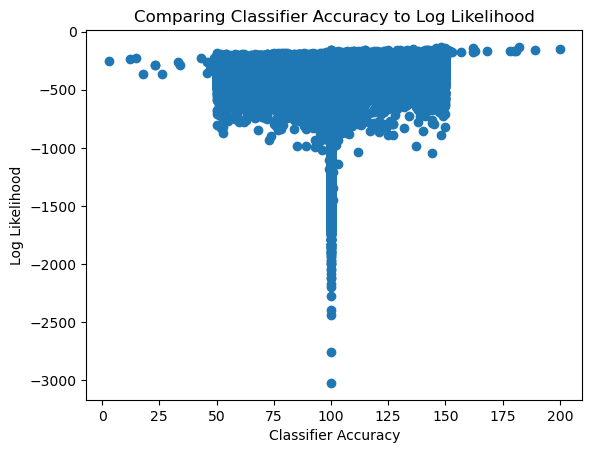

9
-132.1774572916745


In [73]:
#Plot of Log Likelihood Scores
y_samp = classes
x_samp = data
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master

scores = []
accs = []
distances = []
ks = []
best_ks = []
ks = []

(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])
best_dist = euclidean(best_pred_y, classes)


function likelihood(best_trace, best_dist, best_score, best_k, best_acc)
    x_samp, y_samp = data, classes
    obs_master[:y] = y_samp .- 1
    #for i=1:length(classes)
        #obs_master[(:y,i)] = classes[i]
    #end
    obs = obs_master
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    #println(pred_labels)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    dist = euclidean(pred_y, classes)
    score = get_score(trace)
    #println(score)
    if score > best_score
        best_acc = acc
        best_score = score
        best_k = k
        best_trace = trace
        best_dist = dist
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(distances, dist)
    push!(ks, k)
    
    return(best_trace, best_dist, best_score, best_k, best_acc)
end

#Testing specific k value
obs = obs_master
obs[:k] = 9
(best_trace2,) = generate(classifier, (x_samp,), obs)
for i=1:20000
    best_trace2, best_dist, best_score, best_k, best_acc = likelihood(best_trace2, best_dist, best_score, best_k, best_acc)
    push!(best_ks, best_k)
end

obs = obs_master
obs[:k] = 10
(best_trace3,) = generate(classifier, (x_samp,), obs)
for i=1:20000
    best_trace3, best_dist, best_score, best_k, best_acc = likelihood(best_trace3, best_dist, best_score, best_k, best_acc)
    push!(best_ks, best_k)
end

scatter(accs,scores)
#plt.ylim(-500,-450)
#plt.xlim(400,800)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");
println(best_k)
println(best_score)

In [74]:
#Compare 2 and 3 Node Network
println(get_score(best_trace2))
println(get_score(best_trace3))
a2 = best_trace2[:Wₕ]
b2 = best_trace2[:Wₒ]
c2 = best_trace2[:bₕ]
d2 = best_trace2[:bₒ]

a3 = best_trace3[:Wₕ]
b3 = best_trace3[:Wₒ]
c3 = best_trace3[:bₕ]
d3 = best_trace3[:bₒ]

println(a2)
println(a3)
best_trace = best_trace3

-132.1774572916745
-299.05710003043555
[-0.031206511491998472, -1.553556913143043, -1.1408238504530994, -0.08684038793122598, 0.7172794276151576, -1.297232918580915, -0.46349113883721405, -0.17687869590185487, 2.187679744411361, -0.13270418111085452, 0.6732936255110893, -1.8394805294667549, 0.539363370272121, -1.0100937913241783, 1.0625913291702063, -0.11799926612148977, 0.02532242606042246, 1.9849234550734833]
[0.5831089863107637, -1.029119151939397, 0.30542091035286095, 1.5362563286093744, 0.631708859411497, 1.1690000208179498, -0.6902637678671965, 0.17954661005687805, 1.089915870316931, -0.30147921672459904, -0.7587842431152754, -0.24349952297770325, 0.5957658323779387, -0.5121221249794481, 1.4336012634269344, 0.2236415755393271, 1.1564412898061915, 1.2371494093832345, 0.12182285983881455, -2.0112659591628366]


Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,N} where N], false, Union{Nothing, Some{Any}}[nothing], ##classifier#377, Bool[0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:y, 74) => Gen.ChoiceOrCallRecord{Int64}(2, -1.2726845507067372, NaN, true),(:y, 191) => Gen.ChoiceOrCallRecord{Int64}(2, -3.920453151020255, NaN, true),(:y, 105) => Gen.ChoiceOrCallRecord{Int64}(1, -0.03136357054846449, NaN, true),(:y, 20) => Gen.ChoiceOrCallRecord{Int64}(1, -0.039052209163038074, NaN, true),(:y, 51) => Gen.ChoiceOrCallRecord{Int64}(2, -0.9392903501483094, NaN, true),(:y, 6) => Gen.ChoiceOrCallRecord{Int64}(1, -0.025742243571862698, NaN, true),(:y, 73) => Gen.ChoiceOrCallRecord{Int64}(2, -0.7689967884087011, NaN, true),(:y, 123) => Gen.ChoiceOrCallRecord{Int64}(1, -0.05810188599454518, NaN, true),(:y, 187) => Gen.ChoiceOrCallRecord{Int64}(2, -3.5400324713024145, NaN, true),(:y, 144) => G

In [56]:
#Test out Birth and Death Moves for NN
a = best_trace[:Wₕ]
b = best_trace[:Wₒ]
c = best_trace[:bₕ]
d = best_trace[:bₒ]
k = best_trace[:k]
new_k = k+1

difference = abs(new_k - k)
a2 = vcat(a,[0 for i=1:(2*difference)])
b2 = vcat(b,[0 for i=1:difference])
c2 = vcat(c,[1 for i=1:difference])
d2 = d

a2 = zeros(length(a2))
b2 = zeros(length(b2))
c2 = zeros(length(c2))
d2 = zeros(length(d2))

pred_y = G(data,a2,b2,c2,d2,new_k)
pred_labels = data_labeller(pred_y)
acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
println(acc)

obs_new = choicemap()::ChoiceMap
obs_new[:Wₕ] = a2
obs_new[:Wₒ] = b2
obs_new[:bₕ] = c2
obs_new[:bₒ] = d2
obs_new[:k] = new_k

for i=1:length(classes)
    obs_new[(:y,i)] = classes[i]
end
(new_trace, weight) = generate(classifier, (x_samp,), obs_new)

println(a)
println(b)
println(c)
println(d)

println(a2)
println(b2)
println(c2)
println(d2)
println(get_score(best_trace))
println(best_score)
typeof(best_score)
println(get_score(new_trace))
typeof(get_score(new_trace))

100
[1.8970650201908432, 0.24200124323437008, -1.8154459539734047, 1.1869913582124005, 1.614116795112538, -0.5607970431095245]
[-2.5978351974937106, 0.4399719742970887, -1.742734151144341]
[-0.00791339799879176, 1.8144624495811987, 1.2985247617227336]
[2.4288158652167953]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0]
-110.64925586131356
-110.64925586131356
-159.55578826292884


Float64

In [75]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    #new_trace = bernoulli(0.5) ? birth_or_death(new_trace) : new_trace
    return new_trace    
end

@gen function birth(trace)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    #Old Parameters - Deep Copy
    Wₕ = [trace[:Wₕ][i] for i=1:length(trace[:Wₕ])]
    Wₒ = [trace[:Wₒ][i] for i=1:length(trace[:Wₒ])]
    bₕ = [trace[:bₕ][i] for i=1:length(trace[:bₕ])]
    bₒ = [trace[:bₒ][i] for i=1:length(trace[:bₒ])]
    
    #Select Insertion Place for New Neuron
    insert = rand((1:new_k))
    #println(insert)
    
    obs_new = choicemap()::ChoiceMap
    for i=1:length(classes)
        obs_new[(:y,i)] = classes[i]
    end
    obs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    Wₕ = insert!(Wₕ, insert*2-1, normal(0,σₖ))
    obs_new[:Wₕ] = insert!(Wₕ, insert*2, normal(0,σₖ))
    #obs_new[:Wₒ] = vcat(Wₒ,[normal(0,σₖ) for i=1:difference])
    obs_new[:Wₒ] = insert!(Wₒ, insert, normal(0,σₖ))
    obs_new[:bₕ] = insert!(bₕ, insert, normal(1,σₖ))
    obs_new[:bₒ] = bₒ
    #new_Wₕ = vcat(Wₕ,[0 for i=1:(2*difference)])
    #new_Wₒ = vcat(Wₒ,[0 for i=1:difference])
    #new_bₕ = vcat(bₕ,[1 for i=1:difference])
    #new_bₒ = bₒ
    #obs_new[:Wₕ] = zeros(length(new_Wₕ))
    #obs_new[:Wₒ] = zeros(length(new_Wₒ))
    #obs_new[:bₕ] = zeros(length(new_bₕ))
    #obs_new[:bₒ] = zeros(length(new_bₒ))
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    
    #obs_new2 = choicemap()::ChoiceMap
    #for i=1:length(classes)
        #obs_new2[(:y,i)] = classes[i]
    #end
    #obs_new2[:k] = new_k
    #(new_trace2, weight) = generate(classifier, (x_samp,), obs_new2)
    
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    #obs_new[:y] = y_samp .- 1
    for i=1:length(classes)
        obs_new[(:y,i)] = classes[i]
    end
    new_Wₕ = Wₕ[1:new_k*2]
    new_Wₒ = Wₒ[1:new_k]
    new_bₕ = bₕ[1:new_k]
    new_bₒ = bₒ
    obs_new[:Wₕ] = new_Wₕ
    obs_new[:Wₒ] = new_Wₒ
    obs_new[:bₕ] = new_bₕ
    obs_new[:bₒ] = new_bₒ
    #obs_new[:Wₕ] = zeros(length(new_Wₕ))
    #obs_new[:Wₒ] = zeros(length(new_Wₒ))
    #obs_new[:bₕ] = zeros(length(new_bₕ))
    #obs_new[:bₒ] = zeros(length(new_bₒ))
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [85]:
best_trace2 = birth_or_death(best_trace)
println(best_trace[:k])
println(best_trace2[:k])

scorea = get_score(best_trace)
scoreb = get_score(best_trace2)

println(best_trace[:Wₕ])
println(best_trace2[:Wₕ])
println(best_trace[:Wₒ])
println(best_trace2[:Wₒ])

println(scorea)
println(scoreb)

10
11
[0.5831089863107637, -1.029119151939397, 0.30542091035286095, 1.5362563286093744, 0.631708859411497, 1.1690000208179498, -0.6902637678671965, 0.17954661005687805, 1.089915870316931, -0.30147921672459904, -0.7587842431152754, -0.24349952297770325, 0.5957658323779387, -0.5121221249794481, 1.4336012634269344, 0.2236415755393271, 1.1564412898061915, 1.2371494093832345, 0.12182285983881455, -2.0112659591628366]
[0.5831089863107637, -1.029119151939397, -0.7952094676076903, 0.8636700027757406, 0.30542091035286095, 1.5362563286093744, 0.631708859411497, 1.1690000208179498, -0.6902637678671965, 0.17954661005687805, 1.089915870316931, -0.30147921672459904, -0.7587842431152754, -0.24349952297770325, 0.5957658323779387, -0.5121221249794481, 1.4336012634269344, 0.2236415755393271, 1.1564412898061915, 1.2371494093832345, 0.12182285983881455, -2.0112659591628366]
[0.28324952047997054, 0.19528754349732402, -0.8182489223995528, -0.35874784452650216, 0.39321455217881807, -0.5590128452623763, 1.895

In [346]:
a = [best_trace[:Wₒ][i] for i=1:length(best_trace[:Wₒ])]
insert!(a, 2, 1)

3-element Array{Float64,1}:
 -3.984526146710213
  1.0
  3.447739207915854

In [211]:
scorebs = []
best_trace2 = best_trace



for i = 1:3
    best_trace2 = death(best_trace2)
    push!(scorebs, get_score(best_trace2))
end

for i = 1:3
    best_trace2 = birth(best_trace2)
    push!(scorebs, get_score(best_trace2))
end


scorea = get_score(best_trace)
scoreb = get_score(best_trace2)

println(scorea)
println(scoreb)
println(scorebs)


-130.47698328094268
-217.58966459479183
Any[-211.35596485332124, -205.1222651118507, -198.88856537038015, -205.1222651118507, -211.35596485332124, -217.58966459479183]


In [92]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=uniform(0.1,0.15), check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
    end
    return trace
end
eps_list = []
function across_dimension(trace, iters, obs)
    
    new_trace = birth_or_death(trace)
    score_test = get_score(new_trace)
    
    #test = true
    for i=1:iters
        eps = uniform(0.01,0.15)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=20, eps=eps, observations=obs)
        #(new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.02, check=false, observations=obs)
        #accepted && (test = false)
        accepted && (push!(eps_list,eps))
    end
    #test && println("Nothing accepted")
    #test == false && println("Accepted")
    
    #test = true
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    score = exp(score2-score1)
    #println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters

        if (i%100 == 0)
            #current_acc = (sum(acc[length(acc)-10:length(acc)])/11)
            across_acc = (sum(acc_a)/length(acc_a))
            within_acc = (sum(acc_w)/length(acc_w))
            println("Epoch $i Across Acceptance Prob: $across_acc")
            println("Epoch $i Within Acceptance Prob: $within_acc")
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 10, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 20000
starting_trace = best_trace
x_samp, y_samp = data, classes
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master
#obs_master[:y] = y_samp .- 1
obs = obs_master;

#(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 10
New k accepted! Current k: 9
New k accepted! Current k: 8
New k accepted! Current k: 7
New k accepted! Current k: 6
New k accepted! Current k: 5
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
Epoch 100 Across Acceptance Prob: 0.24528301886792453
Epoch 100 Within Acceptance Prob: 0.391304347826087
Epoch 200 Across Acceptance Prob: 0.12380952380952381
Epoch 200 Within Acceptance Prob: 0.44680851063829785
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 300 Across Acceptance Prob: 0.10975609756097561
Epoch 300 Within Acceptance Prob: 0.5555555555555556
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k ac

New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
Epoch 3400 Across Acceptance Prob: 0.10011990407673861
Epoch 3400 Within Acceptance Prob: 0.6857307914500289
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
Epoch 3500 Across Acceptance Prob: 0.09889470622454916
Epoch 3500 Within Acceptance Prob: 0.6859550561797753
Epoch 3600 Across Acceptance Prob: 0.0963718820861678
Epoch 3600 Within Acceptance Prob: 0.6839237057220708
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 3700 Across Acceptance Prob: 0.09581497797356828
Epoch 3700 Within Acceptance Prob: 0.6792352628783855
New k accepted! Current k: 3
New k accepted! Current k: 4
Epoch 3800 Across Acceptance Prob: 0.09416800428036383
Epoch 3800 Within

New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
Epoch 6900 Across Acceptance Prob: 0.09124928036845135
Epoch 6900 Within Acceptance Prob: 0.6823357664233577
New k accepted! Current k: 2
New k accepted! Current k: 3
Epoch 7000 Across Acceptance Prob: 0.09054782855520863
Epoch 7000 Within Acceptance Prob: 0.6829689298043728
New k accepted! Current k: 4
Epoch 7100 Across Acceptance Prob: 0.08971124194000561
Epoch 7100 Within Acceptance Prob: 0.681766704416761
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 7200 Across Acceptance Prob: 0.08919667590027701
Epoch 7200 Within Acceptance Prob: 0.6815268877124547
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
Epoch 7300 Across Acceptance Prob: 0.08962135657858894
Epoch 7300 Within Acceptance Prob: 0.6816427783902976
New k accepted! Curre

New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
Epoch 10600 Across Acceptance Prob: 0.08676140613313388
Epoch 10600 Within Acceptance Prob: 0.6880594172538564
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
Epoch 10700 Across Acceptance Prob: 0.08715766099185789
Epoch 10700 Within Acceptance Prob: 0.686685552407932
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
Epoch 10800 Across Acceptance Prob: 0.08747478452228132
Epoch 10800 Within Acceptance Prob: 0.6883651328095772
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
Epoch 10900 Across Acceptance 

New k accepted! Current k: 3
Epoch 14200 Across Acceptance Prob: 0.08507358093903293
Epoch 14200 Within Acceptance Prob: 0.693233295583239
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
Epoch 14300 Across Acceptance Prob: 0.08503827418232429
Epoch 14300 Within Acceptance Prob: 0.6932808546527973
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
Epoch 14400 Across Acceptance Prob: 0.08525632168025425
Epoch 14400 Within Acceptance Prob: 0.6924043563250488
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 14500 Across Acceptance Prob: 0.08532235939643347
Epoch 14500 Within Acceptance Prob: 0.6926064641420446
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 14600 Across Acceptance Prob:

New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 5
New k accepted! Current k: 4
New k accepted! Current k: 5
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
Epoch 17700 Across Acceptance Prob: 0.08572710951526032
Epoch 17700 Within Acceptance Prob: 0.6864686468646864
New k accepted! Current k: 3
New k accepted! Current k: 2
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 17800 Across Acceptance Prob: 0.0856664807585053
Epoch 17800 Within Acceptance Prob: 0.6872311523658592
New k accepted! Current k: 3
New k accepted! Current k: 2
Epoch 17900 Across Acceptance Prob: 0.08546059933407325
Epoch 17900 Within Acceptance Prob: 0.6879289008887389
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 3
New k accepted! Current k: 4
New k accepted! Current k: 5
N

In [584]:
eps_list

815-element Array{Any,1}:
 0.031072527340519164
 0.06016827857136031
 0.0366475583908832
 0.1316254704442551
 0.03181547763975697
 0.10649548326908467
 0.014731704098756591
 0.1023237318421565
 0.03672928233796546
 0.01865812846793479
 0.07238573129104982
 0.06613921135424303
 0.08432611052638558
 ⋮
 0.06279589856436767
 0.0339906366492341
 0.09785881074869217
 0.09770797698260766
 0.019553921020635023
 0.10858725327782016
 0.11969922291370003
 0.12110912160439004
 0.10453957667112891
 0.11893659078839892
 0.11528197245193891
 0.10650646478413597

In [585]:
[obs[:y][i] == classes for i=1:length(classes)]
#print(classes)
print(obs[:y])

KeyError: KeyError: key :y not found

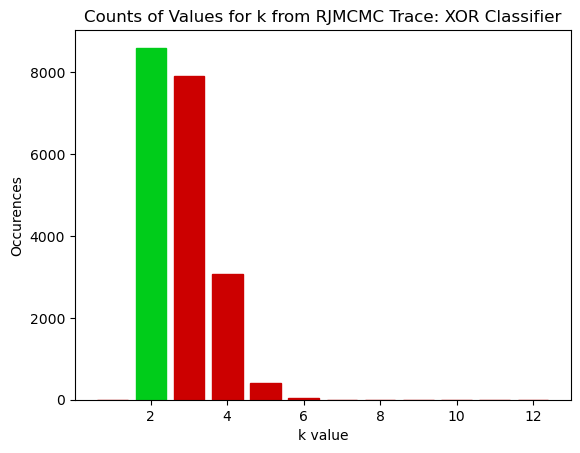

In [97]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Occurences");

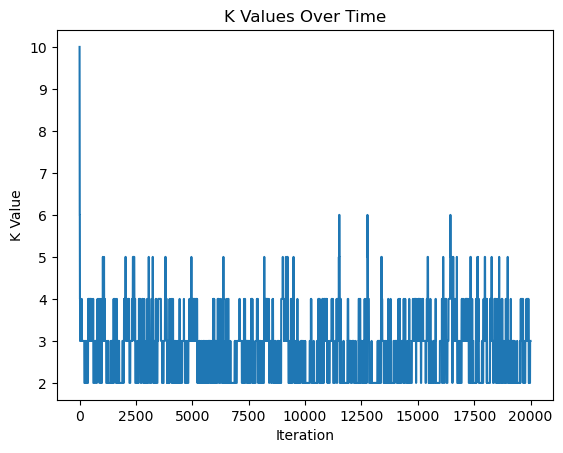

PyObject Text(24.000000000000007, 0.5, 'K Value')

In [98]:
plot(ks)
plt.title("K Values Over Time")
plt.xlabel("Iteration")
plt.ylabel("K Value")

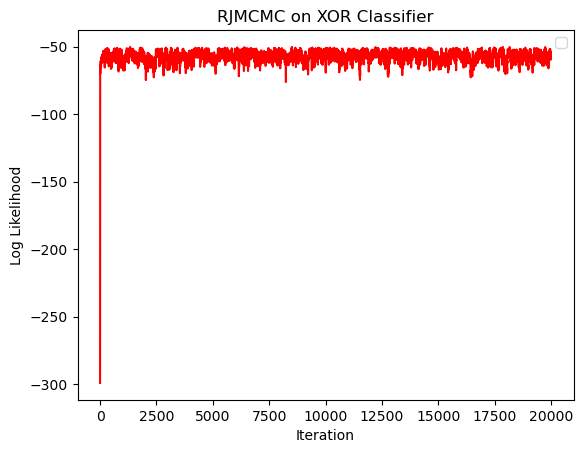

No handles with labels found to put in legend.


In [99]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
best_result = best_trace
scores2 = zeros(length(traces))
for i=1:length(traces)
    trace = traces[i]
    obs = obs_master
    scores2[i] = get_score(trace)
    if get_score(trace) > get_score(best_result)
        best_result = trace
    end
end
plot(scores2, color="red")
#plot(scores2, color="green")
plt.title("RJMCMC on XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

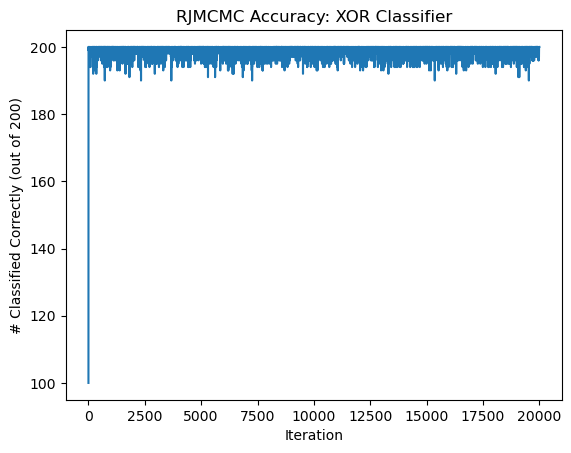

PyObject Text(24.000000000000007, 0.5, '# Classified Correctly (out of 200)')

In [100]:
accs = []
for i=1:length(traces)
    trace = traces[i]
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    
    acc = acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)")

┌ Info: Saved animation to 
│   fn = /home/jberez/Projects/RJMCMC/anim_fps_xor2.gif
└ @ Plots /home/jberez/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jberez/Projects/RJMCMC/anim_fps_xor2.gif")
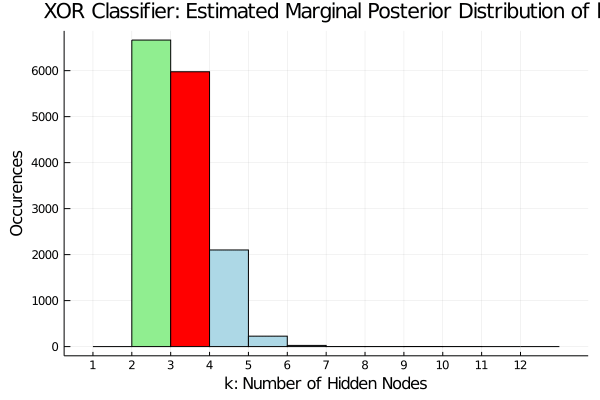

In [125]:
#Try Dynamic Plotting
using Plots
anim = @animate for i ∈ 15000:10:runs
    colors = ["lightblue" for i=1:k_range]
    colors[2] = "lightgreen"
    colors[ks[i]] = "red"
    Plots.histogram(
        ks[1:i], 
        bins=1:k_range+1,
        fillcolor=colors,
        title="XOR Classifier: Estimated Marginal Posterior Distribution of k",
        xlabel="k: Number of Hidden Nodes",
        ylabel="Occurences",
        xticks = 0:1.0:12,
        legend=false
    )
end

gif(anim, "anim_fps_xor2.gif", fps = 2000000)

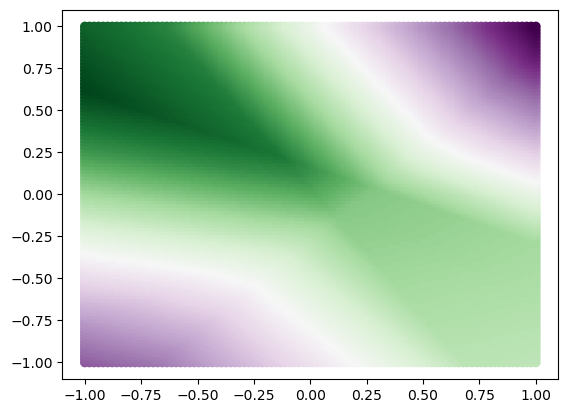

PyObject <matplotlib.collections.PathCollection object at 0x7fd02be55f90>

In [101]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=1000, low=-1.0, high=1.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((1,length(traces)))
        trace = traces[j]
        Wₕ = trace[:Wₕ]
        Wₒ = trace[:Wₒ]
        bₕ = trace[:bₕ]
        bₒ = trace[:bₒ]
        k = trace[:k]
        z = Flux.hardσ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k),0.02)[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)

In [123]:
for i ∈ 1500:10:1600
    println(i)
end

1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


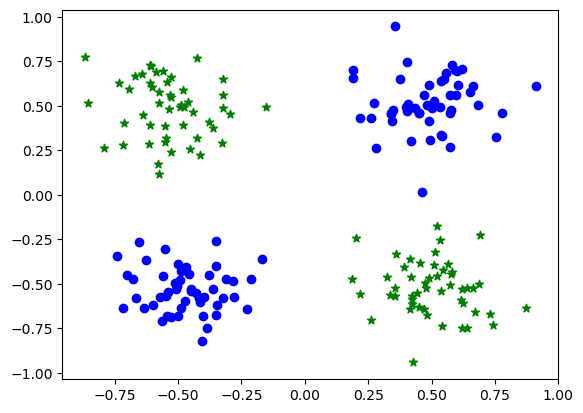

In [590]:
plot_data(data_raw,classes)